In [1]:
# ini
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm

# ============================================================
# 1. DEVICE → PAKAI GPU JIKA ADA
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================================
# 2. LOAD DATA FULL
# ============================================================
train_df = pd.read_csv("train.csv")
dev_df   = pd.read_csv("dev.csv")

label_cols = ["admiration","amusement","gratitude","love","pride","relief","remorse"]

print("Full Train shape:", train_df.shape)
print("Full Dev shape:", dev_df.shape)

# ------------------------------------------------------------
# 2a. SUBSET TRAIN SAJA (4000), DEV PAKAI FULL
# ------------------------------------------------------------
N_TRAIN = len(train_df)

train_df_small = train_df.sample(n=min(N_TRAIN, len(train_df)), random_state=42)
dev_df_full    = dev_df  # pakai semua untuk evaluasi & prediksi

print("Subset Train shape:", train_df_small.shape)
print("Full Dev shape:", dev_df_full.shape)

X_train = train_df_small["text"].astype(str).tolist()
y_train = train_df_small[label_cols].values.astype("float32")

X_dev = dev_df_full["text"].astype(str).tolist()
y_dev = dev_df_full[label_cols].values.astype("float32")

# ============================================================
# 3. TOKENIZER (DistilRoBERTa)
# ============================================================
model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

MAX_LEN = 96

print("Tokenizing train...")
train_enc = tokenizer(
    X_train,
    padding=True,
    truncation=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

print("Tokenizing dev...")
dev_enc = tokenizer(
    X_dev,
    padding=True,
    truncation=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

train_dataset = TensorDataset(
    train_enc["input_ids"],
    train_enc["attention_mask"],
    torch.tensor(y_train, dtype=torch.float32)
)

dev_dataset = TensorDataset(
    dev_enc["input_ids"],
    dev_enc["attention_mask"],
    torch.tensor(y_dev, dtype=torch.float32)
)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader   = DataLoader(dev_dataset,   batch_size=32, shuffle=False)

print("Train batches:", len(train_loader))
print("Dev batches:", len(dev_loader))

# ============================================================
# 4. MODEL (DistilRoBERTa Multi-Label)
# ============================================================
num_labels = len(label_cols)

print("Loading model:", model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="multi_label_classification"
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

# ============================================================
# 5. EVALUATION FUNCTION (FULL DEV)
# ============================================================
def evaluate(threshold=0.5):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for ids, mask, labels in dev_loader:
            ids, mask = ids.to(device), mask.to(device)
            outputs = model(input_ids=ids, attention_mask=mask)
            logits = outputs.logits

            all_logits.append(logits.cpu().numpy())
            all_labels.append(labels.numpy())

    all_logits = np.concatenate(all_logits)
    all_labels = np.concatenate(all_labels)

    probs = 1 / (1 + np.exp(-all_logits))
    preds = (probs >= threshold).astype(int)

    micro = f1_score(all_labels, preds, average="micro")
    macro = f1_score(all_labels, preds, average="macro")

    return micro, macro, probs, preds, all_labels

# ============================================================
# 6. TRAINING LOOP (SUBSET TRAIN, FULL DEV)
# ============================================================
epochs = 10   # 5 epoch biasanya cukup, tiap epoch cuma 4000/16=250 langkah

best_micro = -1.0
best_state = None

for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
    for ids, mask, labels in pbar:
        ids, mask, labels = ids.to(device), mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=ids, attention_mask=mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * ids.size(0)
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = total_loss / len(train_loader.dataset)
    dev_micro, dev_macro, _, _, _ = evaluate(threshold=0.5)

    print(f"\nEpoch {epoch} done | train_loss={train_loss:.4f} | dev_micro={dev_micro:.4f} | dev_macro={dev_macro:.4f}")

    if dev_micro > best_micro:
        best_micro = dev_micro
        best_state = model.state_dict().copy()
        print(f"  → New best model (dev Micro-F1={best_micro:.4f})")

# restore best model
if best_state is not None:
    model.load_state_dict(best_state)
    print("\nBest model restored!")

# ============================================================
# 7. CARI THRESHOLD GLOBAL TERBAIK DI FULL DEV
# ============================================================
print("\nSearching best global threshold on FULL dev...")

best_t = 0.5
best_t_micro = -1.0

for t in np.arange(0.1, 0.9, 0.05):
    micro_t, _, _, _, _ = evaluate(threshold=t)
    print(f"t={t:.2f} → Dev Micro-F1 = {micro_t:.4f}")
    if micro_t > best_t_micro:
        best_t_micro = micro_t
        best_t = t

print(f"\nBEST threshold: {best_t:.2f}")
print(f"BEST dev Micro-F1: {best_t_micro:.4f}")

# ============================================================
# 8. FINAL EVAL + PER-LABEL F1 DI FULL DEV
# ============================================================
final_micro, final_macro, final_probs, final_preds, final_true = evaluate(threshold=best_t)

print("\n========================")
print(" FINAL DEV PERFORMANCE  ")
print("========================")
print(f"Micro-F1 (t={best_t:.2f}): {final_micro:.2f}\n")

for i, col in enumerate(label_cols):
    f1 = f1_score(final_true[:, i], final_preds[:, i])
    print(f"{col.capitalize()} F1: {f1:.2f}")

# ============================================================
# 9. SAVE dev_predictions.csv (FULL DEV)
# ============================================================
output_df = dev_df_full.copy()
for i, col in enumerate(label_cols):
    output_df[col] = final_preds[:, i]

output_df.to_csv("dev_predictions.csv", index=False)
print("\nSaved dev_predictions.csv!")


Using device: cuda
Full Train shape: (25196, 8)
Full Dev shape: (3149, 8)
Subset Train shape: (25196, 8)
Full Dev shape: (3149, 8)
Tokenizing train...
Tokenizing dev...
Train batches: 1575
Dev batches: 99
Loading model: distilroberta-base


2025-12-13 18:06:42.039474: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-13 18:06:42.086088: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-13 18:06:43.002262: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Some weights of Robe

Epoch 1/10:   0%|          | 0/1575 [00:00<?, ?it/s]


Epoch 1 done | train_loss=0.1012 | dev_micro=0.8395 | dev_macro=0.6113
  → New best model (dev Micro-F1=0.8395)


Epoch 2/10:   0%|          | 0/1575 [00:00<?, ?it/s]


Epoch 2 done | train_loss=0.0619 | dev_micro=0.8401 | dev_macro=0.7001
  → New best model (dev Micro-F1=0.8401)


Epoch 3/10:   0%|          | 0/1575 [00:00<?, ?it/s]


Epoch 3 done | train_loss=0.0505 | dev_micro=0.8495 | dev_macro=0.7233
  → New best model (dev Micro-F1=0.8495)


Epoch 4/10:   0%|          | 0/1575 [00:00<?, ?it/s]


Epoch 4 done | train_loss=0.0412 | dev_micro=0.8360 | dev_macro=0.7391


Epoch 5/10:   0%|          | 0/1575 [00:00<?, ?it/s]


Epoch 5 done | train_loss=0.0339 | dev_micro=0.8483 | dev_macro=0.7357


Epoch 6/10:   0%|          | 0/1575 [00:00<?, ?it/s]


Epoch 6 done | train_loss=0.0271 | dev_micro=0.8307 | dev_macro=0.7366


Epoch 7/10:   0%|          | 0/1575 [00:00<?, ?it/s]


Epoch 7 done | train_loss=0.0221 | dev_micro=0.8394 | dev_macro=0.7265


Epoch 8/10:   0%|          | 0/1575 [00:00<?, ?it/s]


Epoch 8 done | train_loss=0.0187 | dev_micro=0.8290 | dev_macro=0.7159


Epoch 9/10:   0%|          | 0/1575 [00:00<?, ?it/s]


Epoch 9 done | train_loss=0.0148 | dev_micro=0.8330 | dev_macro=0.7149


Epoch 10/10:   0%|          | 0/1575 [00:00<?, ?it/s]


Epoch 10 done | train_loss=0.0127 | dev_micro=0.8343 | dev_macro=0.7044

Best model restored!

Searching best global threshold on FULL dev...
t=0.10 → Dev Micro-F1 = 0.8028
t=0.15 → Dev Micro-F1 = 0.8123
t=0.20 → Dev Micro-F1 = 0.8181
t=0.25 → Dev Micro-F1 = 0.8217
t=0.30 → Dev Micro-F1 = 0.8231
t=0.35 → Dev Micro-F1 = 0.8270
t=0.40 → Dev Micro-F1 = 0.8288
t=0.45 → Dev Micro-F1 = 0.8315
t=0.50 → Dev Micro-F1 = 0.8343
t=0.55 → Dev Micro-F1 = 0.8355
t=0.60 → Dev Micro-F1 = 0.8372
t=0.65 → Dev Micro-F1 = 0.8383
t=0.70 → Dev Micro-F1 = 0.8391
t=0.75 → Dev Micro-F1 = 0.8361
t=0.80 → Dev Micro-F1 = 0.8358
t=0.85 → Dev Micro-F1 = 0.8336

BEST threshold: 0.70
BEST dev Micro-F1: 0.8391

 FINAL DEV PERFORMANCE  
Micro-F1 (t=0.70): 0.84

Admiration F1: 0.80
Amusement F1: 0.86
Gratitude F1: 0.92
Love F1: 0.83
Pride F1: 0.55
Relief F1: 0.17
Remorse F1: 0.86

Saved dev_predictions.csv!


In [2]:
from sklearn.metrics import average_precision_score, precision_recall_fscore_support

# urutan label sesuai yang kamu inginkan di tabel/output
ordered_labels = ["gratitude", "remorse", "amusement", "admiration", "love", "pride", "relief"]

rows = []
best_thresholds = {}

for name in ordered_labels:
    i = label_cols.index(name)
    y_true_i = final_true[:, i]
    prob_i   = final_probs[:, i]

    # cari threshold terbaik per label (maksimalkan F1)
    best_f1 = -1.0
    best_t = 0.5
    best_p = 0.0
    best_r = 0.0

    for t in np.arange(0.1, 0.95, 0.01):
        y_pred_i = (prob_i >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(
            y_true_i, y_pred_i, average="binary", zero_division=0
        )
        if f1 > best_f1:
            best_f1 = f1
            best_t  = t
            best_p  = p
            best_r  = r

    ap = average_precision_score(y_true_i, prob_i)

    rows.append({
        "Label": name,
        "AP": ap,
        "Precision": best_p,
        "Recall": best_r,
        "F1": best_f1,
        "Threshold": best_t
    })
    best_thresholds[name] = best_t

metrics_df = pd.DataFrame(rows)
# agar tampilan mirip contoh (3 desimal)
metrics_df_rounded = metrics_df.copy()
for col in ["AP","Precision","Recall","F1","Threshold"]:
    metrics_df_rounded[col] = metrics_df_rounded[col].round(3)

print(metrics_df_rounded)


        Label     AP  Precision  Recall     F1  Threshold
0   gratitude  0.970      0.953   0.897  0.924       0.88
1     remorse  0.896      0.881   0.868  0.874       0.58
2   amusement  0.864      0.844   0.875  0.859       0.67
3  admiration  0.856      0.778   0.820  0.798       0.70
4        love  0.840      0.772   0.901  0.832       0.67
5       pride  0.538      0.727   0.533  0.615       0.82
6      relief  0.164      0.400   0.222  0.286       0.43


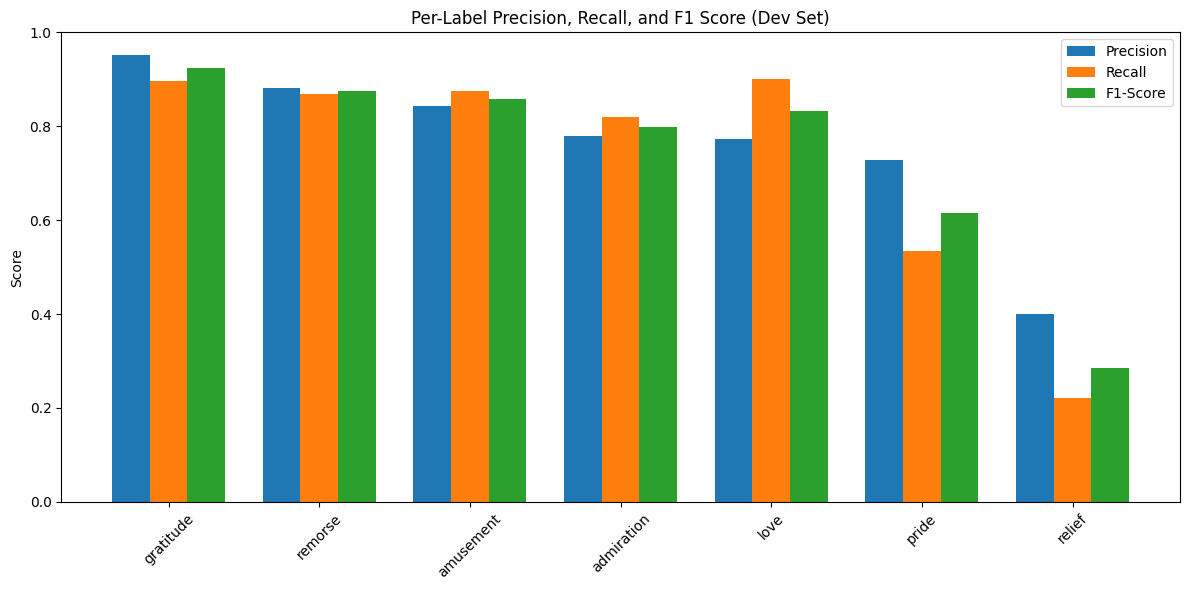

In [3]:
import matplotlib.pyplot as plt
import numpy as np

labels = metrics_df["Label"].tolist()
precisions = metrics_df["Precision"].values
recalls    = metrics_df["Recall"].values
f1s        = metrics_df["F1"].values

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, precisions, width, label="Precision")
plt.bar(x,         recalls,   width, label="Recall")
plt.bar(x + width, f1s,       width, label="F1-Score")

plt.xticks(x, labels, rotation=45)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Per-Label Precision, Recall, and F1 Score (Dev Set)")
plt.legend()
plt.tight_layout()
plt.show()


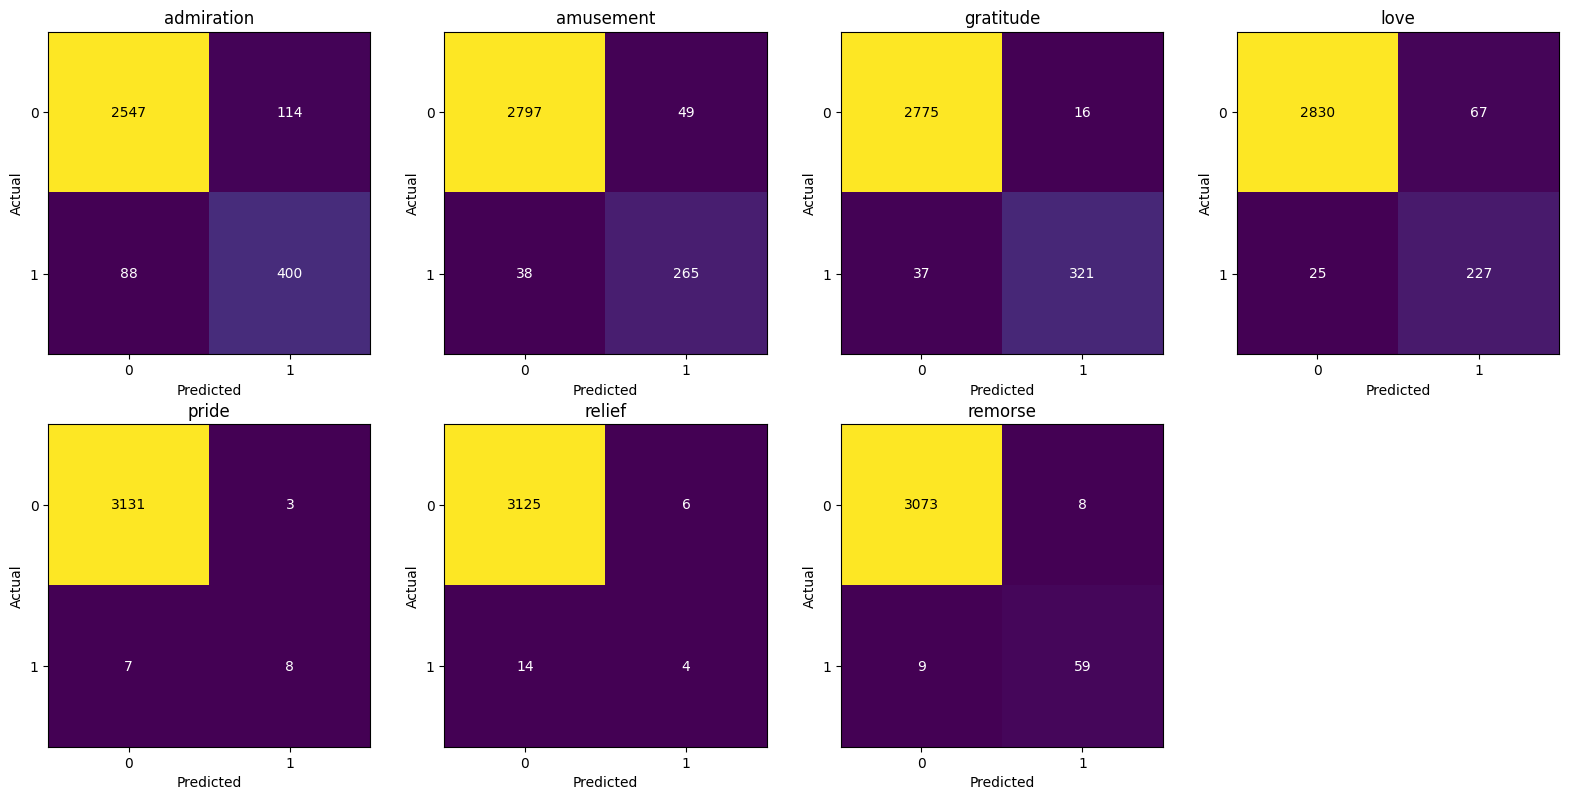

In [4]:
from sklearn.metrics import confusion_matrix

# siapkan prediksi biner per label dengan threshold masing-masing
per_label_preds = np.zeros_like(final_true, dtype=int)

for name in label_cols:
    i = label_cols.index(name)
    t = best_thresholds.get(name, 0.5)  # kalau belum ada, fallback 0.5
    per_label_preds[:, i] = (final_probs[:, i] >= t).astype(int)

# plot confusion matrix per label
num_labels = len(label_cols)
cols = 4
rows = int(np.ceil(num_labels / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
axes = axes.flatten()

for idx, name in enumerate(label_cols):
    i = label_cols.index(name)
    y_true_i = final_true[:, i]
    y_pred_i = per_label_preds[:, i]

    cm = confusion_matrix(y_true_i, y_pred_i, labels=[0, 1])

    ax = axes[idx]
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(name)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    # tulis angka di setiap sel
    for (r, c), val in np.ndenumerate(cm):
        ax.text(c, r, int(val), ha="center", va="center", color="black" if val > cm.max()/2 else "white")

# kalau slot subplot lebih banyak dari label, sembunyikan sisa axis
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()
